<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_LogOHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [2]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [3]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[10] #log transformed
test_file = file_path+file[11]
dataset= "Log Transformed OHE"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 445), (11403, 445), (75818, 445))

In [4]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [5]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [6]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [7]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


The best auc score was 0.812
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 9.48 s, sys: 1.19 s, total: 10.7 s
Wall time: 4min 17s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Log Transformed OHE dataset 		 



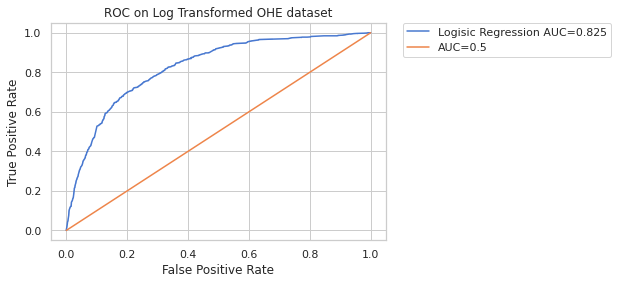

The log loss and auc was found to be 0.519 and 0.825 for Logisic Regression on Log Transformed OHE dataset.


In [9]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [10]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished


The best auc score was 0.790
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'max_depth': 1000}
CPU times: user 5.43 s, sys: 237 ms, total: 5.67 s
Wall time: 6min 22s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                        splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features=None,
                                                             max_leaf_nodes=100,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=500,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
        

		 Decision Tree Classifier on Log Transformed OHE dataset 		 



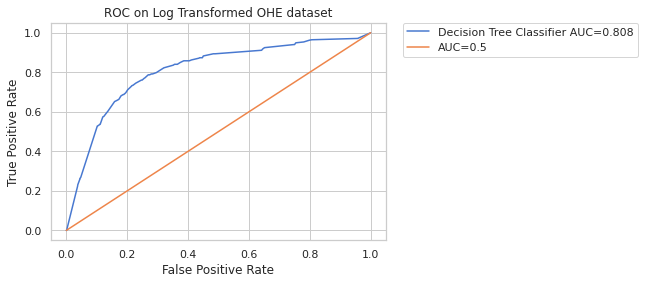

The log loss and auc was found to be 0.141 and 0.808 for Decision Tree Classifier on Log Transformed OHE dataset.


In [13]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [14]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 75.4min finished


The best auc score was 0.818
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 3min 27s, sys: 774 ms, total: 3min 28s
Wall time: 1h 18min 50s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 4min 44s, sys: 605 ms, total: 4min 44s
Wall time: 2min 24s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier on Log Transformed OHE dataset 		 



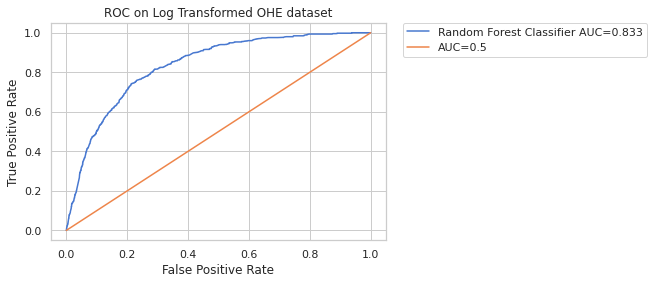

The log loss and auc was found to be 0.137 and 0.833 for Random Forest Classifier on Log Transformed OHE dataset.


In [17]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [18]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430


# Selecting top features

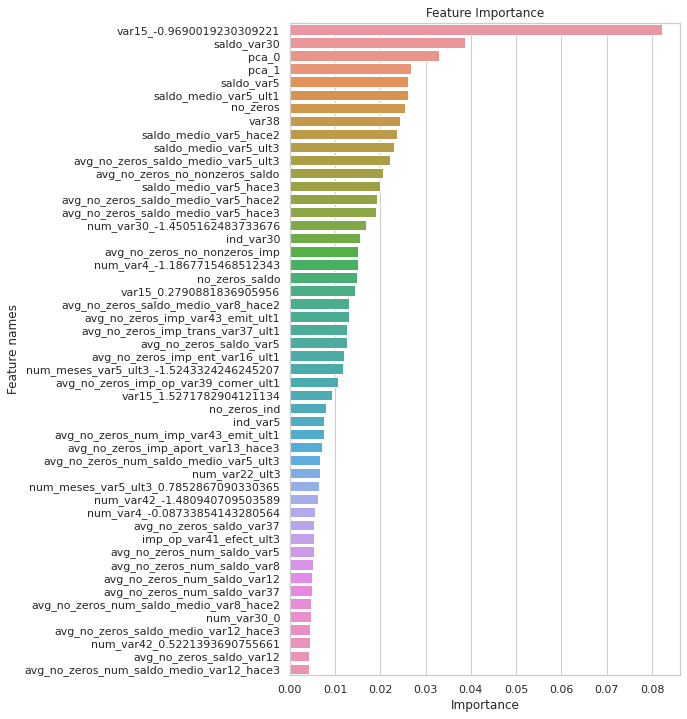

In [19]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [20]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_test[features].copy()

There are 28 features that have feature importance value above 0.01000


In [21]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_test[features].copy()

Taking top 100 features


In [22]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_test[features].copy()

Taking top 250 features


# XGB Classifier

In [23]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.7,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500,
                      reg_alpha = 0.,
                      max_depth=5, random_state=42
                     )


In [24]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.80575	validation_0-error:0.039551
[1]	validation_0-auc:0.817007	validation_0-error:0.039551
[2]	validation_0-auc:0.816031	validation_0-error:0.039639
[3]	validation_0-auc:0.817822	validation_0-error:0.039551
[4]	validation_0-auc:0.821547	validation_0-error:0.039551
[5]	validation_0-auc:0.824036	validation_0-error:0.039551
[6]	validation_0-auc:0.824589	validation_0-error:0.039551
[7]	validation_0-auc:0.825237	validation_0-error:0.039551
[8]	validation_0-auc:0.827151	validation_0-error:0.039551
[9]	validation_0-auc:0.827757	validation_0-error:0.039551
[10]	validation_0-auc:0.827859	validation_0-error:0.039551
[11]	validation_0-auc:0.82745	validation_0-error:0.039551
[12]	validation_0-auc:0.828113	validation_0-error:0.039551
[13]	validation_0-auc:0.827972	validation_0-error:0.039551
[14]	validation_0-auc:0.828137	validation_0-error:0.039551
[15]	validation_0-auc:0.828712	validation_0-error:0.039551
[16]	validation_0-auc:0.828745	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

		 XGBoost Classifer on Log Transformed OHE dataset 		 



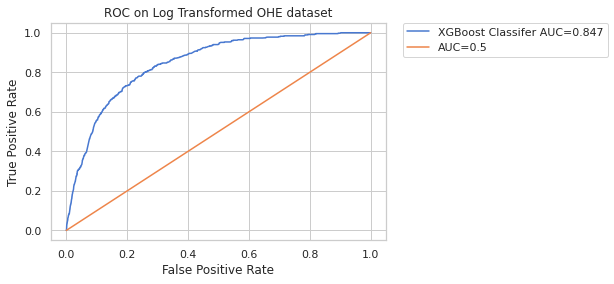

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer on Log Transformed OHE dataset.


In [25]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [26]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050


# LightGBM Classifier

In [27]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=375,
                      reg_alpha = 0.4,
                      max_depth=7, random_state=42
                     )


In [28]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.800463	valid_0's binary_logloss: 0.165134
[2]	valid_0's auc: 0.80078	valid_0's binary_logloss: 0.163921
[3]	valid_0's auc: 0.826833	valid_0's binary_logloss: 0.162642
[4]	valid_0's auc: 0.830208	valid_0's binary_logloss: 0.161407
[5]	valid_0's auc: 0.833839	valid_0's binary_logloss: 0.160316
[6]	valid_0's auc: 0.835159	valid_0's binary_logloss: 0.159218
[7]	valid_0's auc: 0.835746	valid_0's binary_logloss: 0.158246
[8]	valid_0's auc: 0.835174	valid_0's binary_logloss: 0.157428
[9]	valid_0's auc: 0.836429	valid_0's binary_logloss: 0.156529
[10]	valid_0's auc: 0.836928	valid_0's binary_logloss: 0.155743
[11]	valid_0's auc: 0.837121	valid_0's binary_logloss: 0.155029
[12]	valid_0's auc: 0.83903	valid_0's binary_logloss: 0.154218
[13]	valid_0's auc: 0.838198	valid_0's binary_logloss: 0.153553
[14]	valid_0's auc: 0.837598	valid_0's binary_logloss: 0.153038
[15]	valid_0's auc: 0.837505	valid_0's binary_logloss: 0.152462
[16]	valid_0's auc: 0.837637	valid_0's binary_loglo

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.02, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=375, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Log Transformed OHE dataset 		 



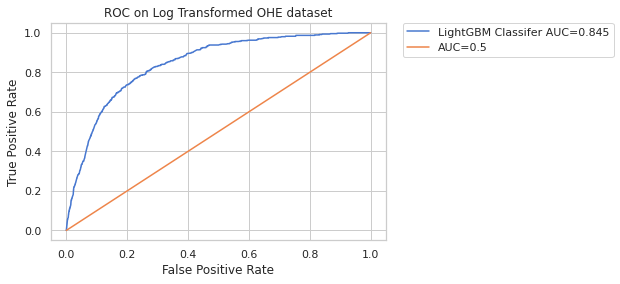

The log loss and auc was found to be 0.133 and 0.845 for LightGBM Classifer on Log Transformed OHE dataset.


In [29]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [30]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 39.6min finished


The best auc score was 0.820
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 100, 'max_depth': 500}
CPU times: user 3min, sys: 561 ms, total: 3min
Wall time: 42min 39s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [32]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=2000,
                                                             max_features='auto',
                                                             max_leaf_nodes=100,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (feature importance>0.01) on Log Transformed OHE dataset 		 



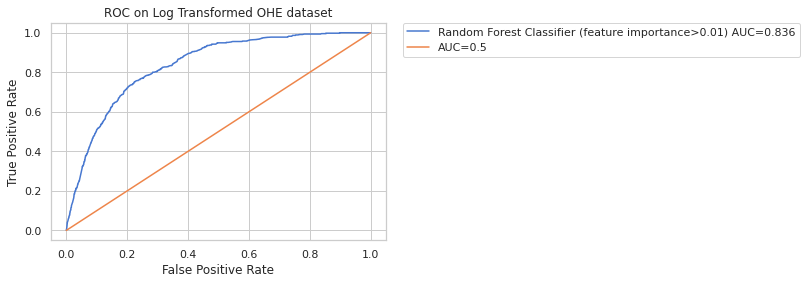

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (feature importance>0.01) on Log Transformed OHE dataset.


In [33]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [34]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518


# XGB Classifier (feature importance>0.01)

In [35]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.8,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=5, random_state=42
                     )


In [36]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.819541	validation_0-error:0.039551
[1]	validation_0-auc:0.82359	validation_0-error:0.039551
[2]	validation_0-auc:0.820631	validation_0-error:0.039551
[3]	validation_0-auc:0.825083	validation_0-error:0.039551
[4]	validation_0-auc:0.824606	validation_0-error:0.039551
[5]	validation_0-auc:0.824985	validation_0-error:0.039551
[6]	validation_0-auc:0.822717	validation_0-error:0.039551
[7]	validation_0-auc:0.825372	validation_0-error:0.039551
[8]	validation_0-auc:0.824325	validation_0-error:0.039551
[9]	validation_0-auc:0.823595	validation_0-error:0.039551
[10]	validation_0-auc:0.822945	validation_0-error:0.039551
[11]	validation_0-auc:0.826059	validation_0-error:0.039551
[12]	validation_0-auc:0.824324	validation_0-error:0.039551
[13]	validation_0-auc:0.824875	validation_0-error:0.039551
[14]	validation_0-auc:0.823863	validation_0-error:0.039551
[15]	validation_0-auc:0.824578	validation_0-error:0.039551
[16]	validation_0-auc:0.82443	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Log Transformed OHE dataset 		 



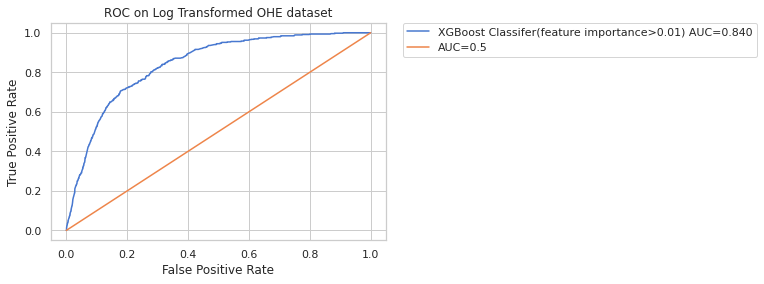

The log loss and auc was found to be 0.135 and 0.840 for XGBoost Classifer(feature importance>0.01) on Log Transformed OHE dataset.


In [37]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [38]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120


# LightGBM Classifier (feature importance>0.01)

In [39]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=740,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5, random_state=42
                     )

In [40]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.788735	valid_0's binary_logloss: 0.165846
[2]	valid_0's auc: 0.794857	valid_0's binary_logloss: 0.165252
[3]	valid_0's auc: 0.816793	valid_0's binary_logloss: 0.164564
[4]	valid_0's auc: 0.82187	valid_0's binary_logloss: 0.163886
[5]	valid_0's auc: 0.825541	valid_0's binary_logloss: 0.163281
[6]	valid_0's auc: 0.827828	valid_0's binary_logloss: 0.16269
[7]	valid_0's auc: 0.825882	valid_0's binary_logloss: 0.162187
[8]	valid_0's auc: 0.82484	valid_0's binary_logloss: 0.161685
[9]	valid_0's auc: 0.826977	valid_0's binary_logloss: 0.161134
[10]	valid_0's auc: 0.829195	valid_0's binary_logloss: 0.160594
[11]	valid_0's auc: 0.829415	valid_0's binary_logloss: 0.160103
[12]	valid_0's auc: 0.829924	valid_0's binary_logloss: 0.159602
[13]	valid_0's auc: 0.830455	valid_0's binary_logloss: 0.159108
[14]	valid_0's auc: 0.830641	valid_0's binary_logloss: 0.158733
[15]	valid_0's auc: 0.830767	valid_0's binary_logloss: 0.158326
[16]	valid_0's auc: 0.829644	valid_0's binary_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=740, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Log Transformed OHE dataset 		 



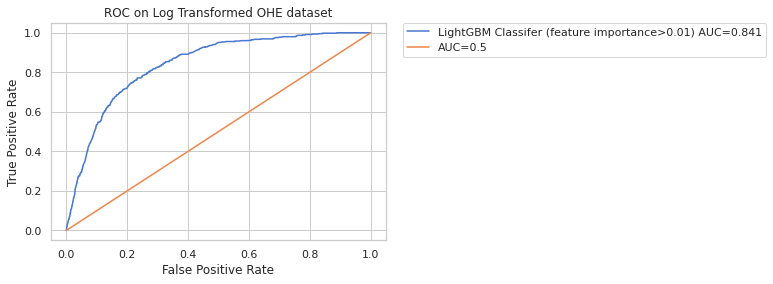

The log loss and auc was found to be 0.135 and 0.841 for LightGBM Classifer (feature importance>0.01) on Log Transformed OHE dataset.


In [41]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [42]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134646,0.841300


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 42.1min finished


The best auc score was 0.823
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 12s, sys: 446 ms, total: 2min 13s
Wall time: 44min 17s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [44]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Log Transformed OHE dataset 		 



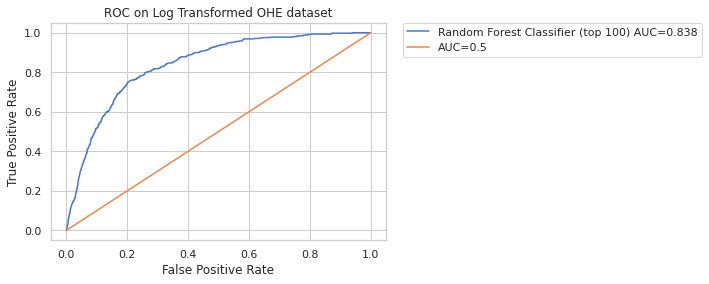

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 100) on Log Transformed OHE dataset.


In [45]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [46]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134646,0.841300
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089


# XGB Classifier (top 100)

In [47]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 1,
                      max_depth=5, random_state=42
                     )


In [48]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.814268	validation_0-error:0.039551
[1]	validation_0-auc:0.822387	validation_0-error:0.039551
[2]	validation_0-auc:0.82147	validation_0-error:0.039551
[3]	validation_0-auc:0.818015	validation_0-error:0.039551
[4]	validation_0-auc:0.820033	validation_0-error:0.039551
[5]	validation_0-auc:0.820074	validation_0-error:0.039551
[6]	validation_0-auc:0.820507	validation_0-error:0.039551
[7]	validation_0-auc:0.819744	validation_0-error:0.039551
[8]	validation_0-auc:0.819752	validation_0-error:0.039551
[9]	validation_0-auc:0.820072	validation_0-error:0.039551
[10]	validation_0-auc:0.819948	validation_0-error:0.039551
[11]	validation_0-auc:0.8189	validation_0-error:0.039551
[12]	validation_0-auc:0.818515	validation_0-error:0.039551
[13]	validation_0-auc:0.818666	validation_0-error:0.039551
[14]	validation_0-auc:0.819357	validation_0-error:0.039551
[15]	validation_0-auc:0.81882	validation_0-error:0.039551
[16]	validation_0-auc:0.8187	validation_0-error:0.039551
[17]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Log Transformed OHE dataset 		 



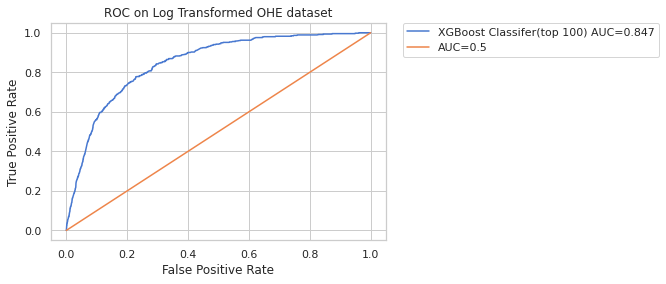

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 100) on Log Transformed OHE dataset.


In [49]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [50]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134646,0.841300
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132889,0.847012


# LightGBM Classifier (top 100)

In [51]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.4,
                      max_depth=5 , random_state=42
                     )


In [52]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.804202	valid_0's binary_logloss: 0.165825
[2]	valid_0's auc: 0.807613	valid_0's binary_logloss: 0.165248
[3]	valid_0's auc: 0.809863	valid_0's binary_logloss: 0.164648
[4]	valid_0's auc: 0.821285	valid_0's binary_logloss: 0.163982
[5]	valid_0's auc: 0.822674	valid_0's binary_logloss: 0.16337
[6]	valid_0's auc: 0.823029	valid_0's binary_logloss: 0.162824
[7]	valid_0's auc: 0.82491	valid_0's binary_logloss: 0.16228
[8]	valid_0's auc: 0.826132	valid_0's binary_logloss: 0.161732
[9]	valid_0's auc: 0.826385	valid_0's binary_logloss: 0.161249
[10]	valid_0's auc: 0.826394	valid_0's binary_logloss: 0.160782
[11]	valid_0's auc: 0.825736	valid_0's binary_logloss: 0.160333
[12]	valid_0's auc: 0.825856	valid_0's binary_logloss: 0.159882
[13]	valid_0's auc: 0.824244	valid_0's binary_logloss: 0.159463
[14]	valid_0's auc: 0.826214	valid_0's binary_logloss: 0.158976
[15]	valid_0's auc: 0.827828	valid_0's binary_logloss: 0.158505
[16]	valid_0's auc: 0.827515	valid_0's binary_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=947, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Log Transformed OHE dataset 		 



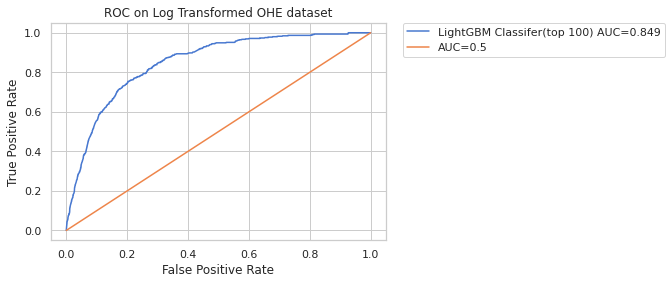

The log loss and auc was found to be 0.132 and 0.849 for LightGBM Classifer(top 100) on Log Transformed OHE dataset.


In [53]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [54]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134646,0.841300
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132889,0.847012


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 54.4min finished


The best auc score was 0.820
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 58s, sys: 552 ms, total: 2min 58s
Wall time: 57min 23s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [56]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Log Transformed OHE dataset 		 



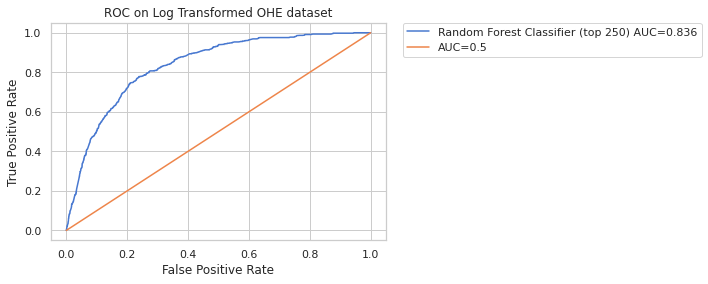

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (top 250) on Log Transformed OHE dataset.


In [57]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [58]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134646,0.841300
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132889,0.847012


# XGB Classifier (top 250)

In [59]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0,
                      max_depth=6, random_state=42
                     )

In [60]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.802565	validation_0-error:0.040428
[1]	validation_0-auc:0.802251	validation_0-error:0.039989
[2]	validation_0-auc:0.808119	validation_0-error:0.039989
[3]	validation_0-auc:0.816679	validation_0-error:0.039639
[4]	validation_0-auc:0.818312	validation_0-error:0.039551
[5]	validation_0-auc:0.822607	validation_0-error:0.039551
[6]	validation_0-auc:0.823224	validation_0-error:0.039551
[7]	validation_0-auc:0.823458	validation_0-error:0.039551
[8]	validation_0-auc:0.824167	validation_0-error:0.039551
[9]	validation_0-auc:0.825835	validation_0-error:0.039551
[10]	validation_0-auc:0.826855	validation_0-error:0.039551
[11]	validation_0-auc:0.827132	validation_0-error:0.039551
[12]	validation_0-auc:0.827883	validation_0-error:0.039551
[13]	validation_0-auc:0.826349	validation_0-error:0.039551
[14]	validation_0-auc:0.826639	validation_0-error:0.039551
[15]	validation_0-auc:0.827605	validation_0-error:0.039551
[16]	validation_0-auc:0.82955	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Log Transformed OHE dataset 		 



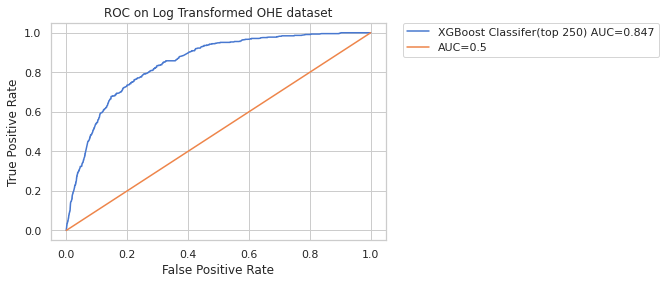

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 250) on Log Transformed OHE dataset.


In [61]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [62]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134646,0.841300
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132889,0.847012


# LightGBM Classifier (top 250)

In [63]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = .8,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=8, random_state=42
                     )

In [64]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.802908	valid_0's binary_logloss: 0.165815
[2]	valid_0's auc: 0.825664	valid_0's binary_logloss: 0.165103
[3]	valid_0's auc: 0.824855	valid_0's binary_logloss: 0.16449
[4]	valid_0's auc: 0.829185	valid_0's binary_logloss: 0.163824
[5]	valid_0's auc: 0.829139	valid_0's binary_logloss: 0.163244
[6]	valid_0's auc: 0.831428	valid_0's binary_logloss: 0.162584
[7]	valid_0's auc: 0.832749	valid_0's binary_logloss: 0.161965
[8]	valid_0's auc: 0.831794	valid_0's binary_logloss: 0.161436
[9]	valid_0's auc: 0.830453	valid_0's binary_logloss: 0.161016
[10]	valid_0's auc: 0.830888	valid_0's binary_logloss: 0.160475
[11]	valid_0's auc: 0.83077	valid_0's binary_logloss: 0.159948
[12]	valid_0's auc: 0.831844	valid_0's binary_logloss: 0.159396
[13]	valid_0's auc: 0.83287	valid_0's binary_logloss: 0.15893
[14]	valid_0's auc: 0.83228	valid_0's binary_logloss: 0.158515
[15]	valid_0's auc: 0.832351	valid_0's binary_logloss: 0.158068
[16]	valid_0's auc: 0.83292	valid_0's binary_logloss: 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=447, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Log Transformed OHE dataset 		 



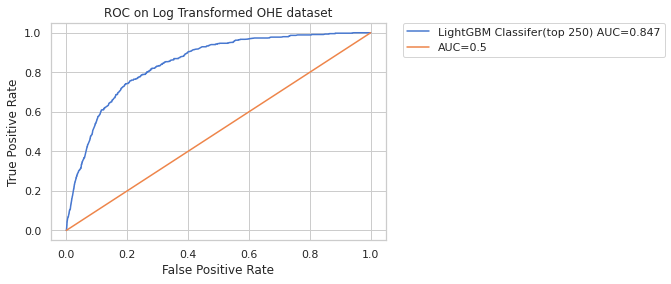

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer(top 250) on Log Transformed OHE dataset.


In [65]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

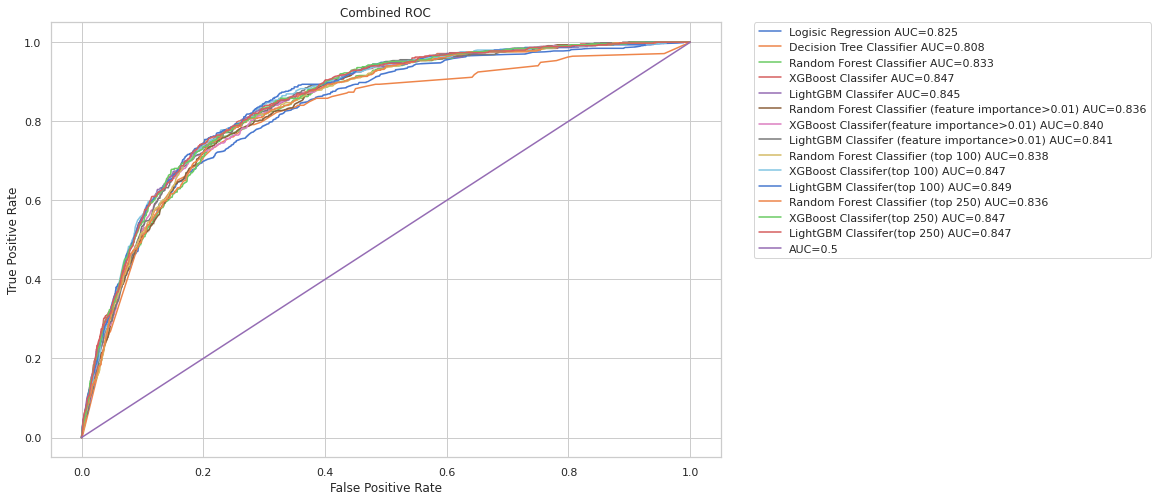

In [66]:
plot_auc(y_val,y_preds,labels)

In [67]:
result_df.sort_values(by='log_loss')

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Log Transformed OHE,0.132282,0.848959
3,XGBoost Classifer,Log Transformed OHE,0.132767,0.847050
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132889,0.847012
12,XGBoost Classifer(top 250),Log Transformed OHE,0.132942,0.846632
13,LightGBM Classifer(top 250),Log Transformed OHE,0.133092,0.846830
4,LightGBM Classifer,Log Transformed OHE,0.133097,0.844821
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134646,0.841300
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134841,0.840120
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518


# Saving all the datasets created

In [68]:
import joblib
filename = 'log_train_ohe_100.pkl'
X_train_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_ohe_100.pkl'
X_val_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_ohe_100.pkl'
X_test_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_train_ohe_250.pkl'
X_train_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_ohe_250.pkl'
X_val_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_ohe_250.pkl'
X_test_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_train_ohe_01.pkl'
X_train_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_ohe_01.pkl'
X_val_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_ohe_01.pkl'
X_test_01.to_pickle(os.path.join(file_path,'best_models',filename))